In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Crime prediction from Hawkes processes

Here we continue to explore the EM algorithm for Hawkes processes, but now concentrating upon:

1. Mohler et al. "Randomized Controlled Field Trials of Predictive Policing". Journal of the American Statistical Association (2015) DOI:10.1080/01621459.2015.1077710

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation of the process in a single cell

In [3]:
import open_cp.sources.sepp as source_sepp

[(-0.1, 0.1), (900, 1000)]

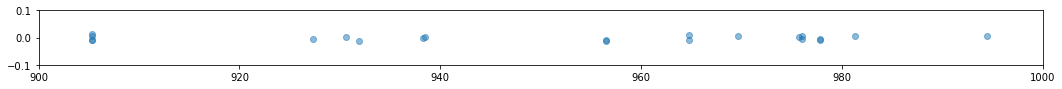

In [4]:
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=10))

events = process.sample(0, 1000)

fig, ax = plt.subplots(figsize=(18,1))
ax.scatter(events, (np.random.random(len(events))-0.5) * 0.03, alpha=.5)
ax.set(xlim=[900, 1000], ylim=[-0.1,0.1])

## Model fitting for cells with varying background rate

We'll create 100 cells with varying background rate, but the same $\omega, \theta$.  We use our library to perform this simulation.

In [5]:
rates = [0.01 + 0.49 * i / 100 for i in range(100)]
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
cells = simulation.sample(0, 1000)

To simulate a steady state, we'll discard the first half of time in each cell.

In [6]:
for i in range(100):
    times = cells[i]
    cells[i] = times[times>=500] - 500

The number of events in each cell varies quite a lot.

In [7]:
min(len(t) for t in cells), max(len(t) for t in cells)

(3, 532)

In [8]:
### OLLLLDDDDDDDDDDD

def simulate(exp_rate=10):
    cells = np.empty(100, dtype=np.object)
    for i in range(100):
        rate = 0.01 + 0.49 * i / 100
        process = source_sepp.SelfExcitingPointProcess(
            background_sampler = source_sepp.HomogeneousPoissonSampler(rate=rate),
            trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=exp_rate))
        events = process.sample(0, 1000)
        cells[i] = events[events >= 500]
        cells[i] -= cells[i][0]
    return cells

In [9]:
import open_cp.seppexp

In [10]:
def optimise(cells, initial_omega=10, iterations=100):
    omega = initial_omega
    theta = .5
    mu = [.5] * len(cells)

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation(cells, omega, theta, mu, 500)
    return omega, theta, mu

def optimise_corrected(cells, initial_omega=10, iterations=100):
    omega = initial_omega
    theta = .5
    mu = [.5] * len(cells)

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation_corrected(cells, omega, theta, mu, 500)
    return omega, theta, mu

In [11]:
omega, theta, mu = optimise(cells)
omega, theta

(10.012190153980091, 0.49581402922437362)

In [12]:
omegac, thetac, muc = optimise_corrected(cells, 0.1, 1000)
omegac, thetac

(10.00854955122975, 0.4959268511094797)

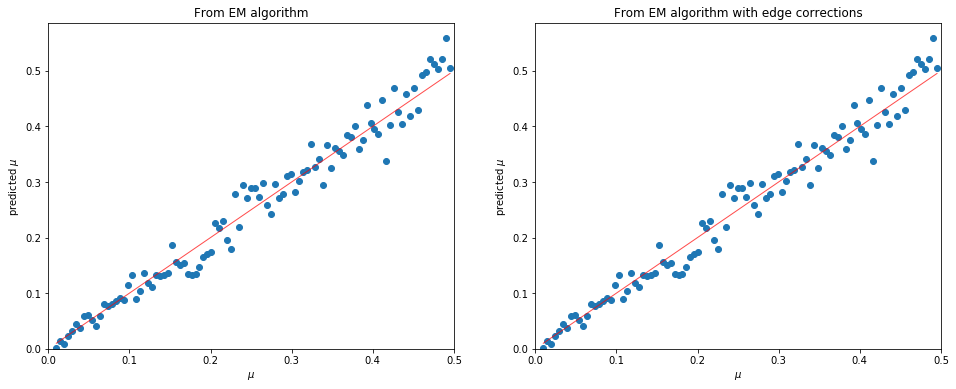

In [13]:
actual_mu = [ 0.01 + 0.49 * i / 100 for i in range(100) ]

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[0].scatter(actual_mu, mu)
ax[0].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm")
ax[1].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[1].scatter(actual_mu, muc)
ax[1].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm with edge corrections")
None

Noting that our initial estimate for every $\mu$ is $0.5$, this is good convergence.

However, if we try a rather smaller value of $\omega$, then the optimisation doesn't find the real parameters, tending to systematically over-estimate the background rate $\mu$ and under-estimate the aftershock rate.

In [14]:
cells = simulate(0.1)
omega, theta, mu = optimise(cells, 0.1, 1000)
omega, theta

(0.21362213685143369, 0.29635488525511644)

In [15]:
omegac, thetac, muc = optimise_corrected(cells, 0.1, 1000)
omegac, thetac

(0.13906657670856143, 0.37841707492438925)

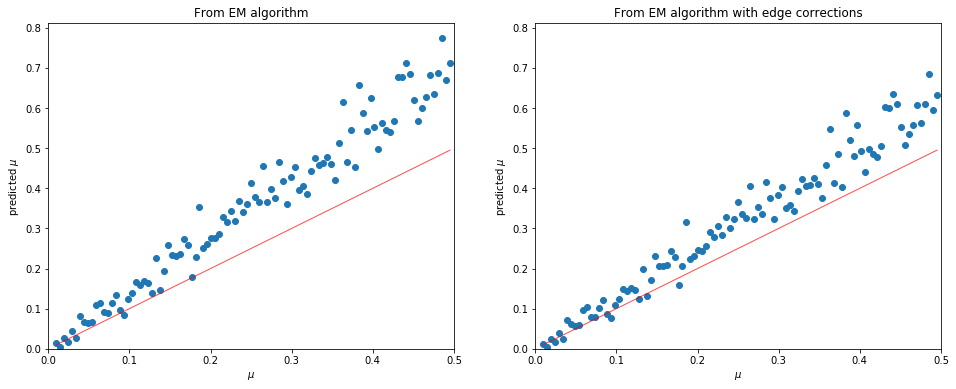

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax[0].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[0].scatter(actual_mu, mu)
ax[0].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm")
ax[1].plot(actual_mu, actual_mu, color="red", linewidth=1, alpha=0.7)
ax[1].scatter(actual_mu, muc)
ax[1].set(xlim=[0,0.5], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title="From EM algorithm with edge corrections")
None